# Лабораторная работа №1 (проведение исследований с алгоритмом KNN)

In [646]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## 1. Выбор начальных условий
### Набор данных для классификации

In [647]:
glass_dataset = fetch_ucirepo(id=42)


In [648]:
df = pd.DataFrame(data=glass_dataset.data.features)
df['Glass'] = glass_dataset.data.targets

In [649]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Описание столбцов
- RI: коэффициент отражения
- Na: натрий (единица измерения: массовая доля в соответствующем оксиде, аналогично в атрибутах 4-10)
- Mg: магний
- Al: алюминий
- Si: кремний
- K: калий
- Ca: кальций
- Ba: барий
- Fe: железо
- Glass (виды стекол):
    - 1 -> окна зданий, термополированное стекло
    - 2 -> окна зданий, нетермополированное стекло
    - 3 -> окна для транспортных средств, термополированное стекло
    - 4 -> окна для транспортных средств, нетермополированное стекло (в этой базе данных их нет)
    - 5 -> стекло для контейнеров
    - 6 -> стекло для столовых приборов
    - 7 -> стекло для фар

In [650]:
# Проверим типы колонок

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Glass   214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Как мы можем видеть, в наборе данных все  переменные числовые и отсутствуют пропущенные значения.
Однако имеющиеся целевые значения заменены цифрами для сокращения объема датасета. Созданим список классов целевых значений для упрощения интерпретации предсказаний моделей. 

In [651]:
target_column = "Glass"

class_names = [
    "building_windows_float_processed",
    "building_windows_non_float_processed",
    "vehicle_windows_float_processed",
    "vehicle_windows_non_float_processed",
    "containers",
    "tableware",
    "headlamps",
    ]

# df[target_column] = df[target_column].apply(lambda x: class_names[x-1])
# df[target_column].head()

Разобьем выборку на обучающую и валидационную

In [652]:
train, valid = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target_column])

In [653]:
X_train = train.drop(columns=target_column, inplace=False)
y_train = train[target_column]

X_valid = valid.drop(columns=target_column, inplace=False)
y_valid = valid[target_column]

- В качестве датасета для классификации я взял 7 видов стекла, определяемых по содержанию в них оксидов (например, Na, Fe, K и т.д.)
- Таргет - Glass: тип стекла
- В качестве метрики качества буду использовать F1-score, тк хорошая метрика для классификации, учитывающая точность и полноту, Balanced Accuracy, тк она проще всего для понимания и учитывает дисбаланс классов, и в отдельности Precision и Recall

## 2. Создание бейзлайна и оценка качества

### Обучение модели

Определим модель и обучим модель

In [654]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

Сделаем предсказания

In [655]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### Оценка качества модели

У нас мультиклассовая классификация, но класс `vehicle_windows_non_float_processed` отсутствует среди истинных меток классов

In [656]:
df[target_column].nunique()

6

Поэтому метрики будем вычислять, используя параметры `average='macro'` и `zero_division=1` 

In [657]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [658]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.661651,0.582751
1,Balanced Accuracy,0.627654,0.576190
2,Precision,0.766055,0.627089
3,Recall,0.627654,0.576190


Визуализируем метрики

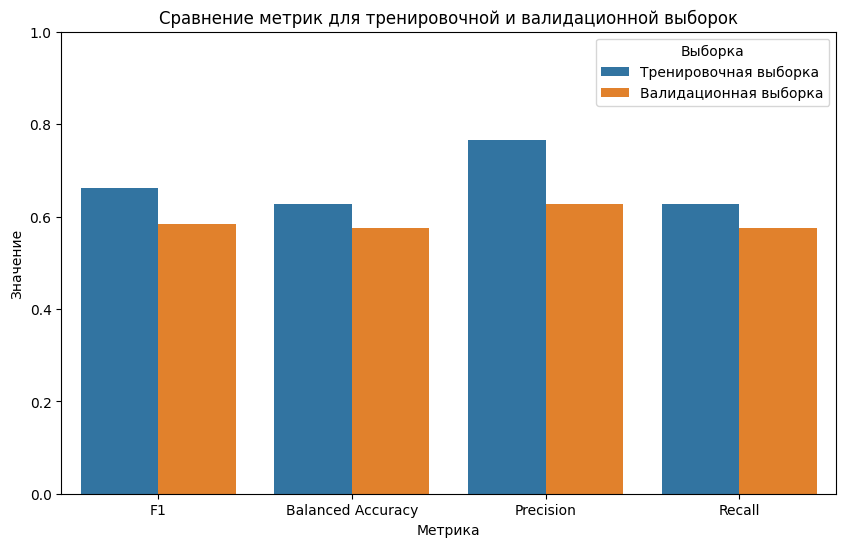

In [659]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## 3. Улучшение бейзлайна

### Препроцессинг данных

In [660]:
df_optimized = df.copy()

Проверка пустых значений

In [661]:
df_optimized.isna().sum()

RI       0
Na       0
Mg       0
Al       0
Si       0
K        0
Ca       0
Ba       0
Fe       0
Glass    0
dtype: int64

Проверка числа уникальных значений в каждом столбце 

In [662]:
df_optimized.nunique()

RI       178
Na       142
Mg        94
Al       118
Si       133
K         65
Ca       143
Ba        34
Fe        32
Glass      6
dtype: int64

Проверка основных характеристик фичей

In [663]:
df_optimized.describe().round(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Glass
count,214.00,214.00,214.00,214.00,214.00,214.00,214.00,214.00,214.00,214.00
mean,1.52,13.41,2.68,1.44,72.65,0.50,8.96,0.18,0.06,2.78
std,0.00,0.82,1.44,0.50,0.77,0.65,1.42,0.50,0.10,2.10
min,1.51,10.73,0.00,0.29,69.81,0.00,5.43,0.00,0.00,1.00
25%,1.52,12.91,2.11,1.19,72.28,0.12,8.24,0.00,0.00,1.00
50%,1.52,13.30,3.48,1.36,72.79,0.56,8.60,0.00,0.00,2.00
75%,1.52,13.82,3.60,1.63,73.09,0.61,9.17,0.00,0.10,3.00
max,1.53,17.38,4.49,3.50,75.41,6.21,16.19,3.15,0.51,7.00


Поиск дубликатов

In [664]:
df_optimized[df_optimized.duplicated(keep=False)]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Glass
38,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


Найден дубликат, удалим его

In [665]:
df_optimized = df_optimized.drop_duplicates()
df_optimized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Glass   213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


Визуализация данных

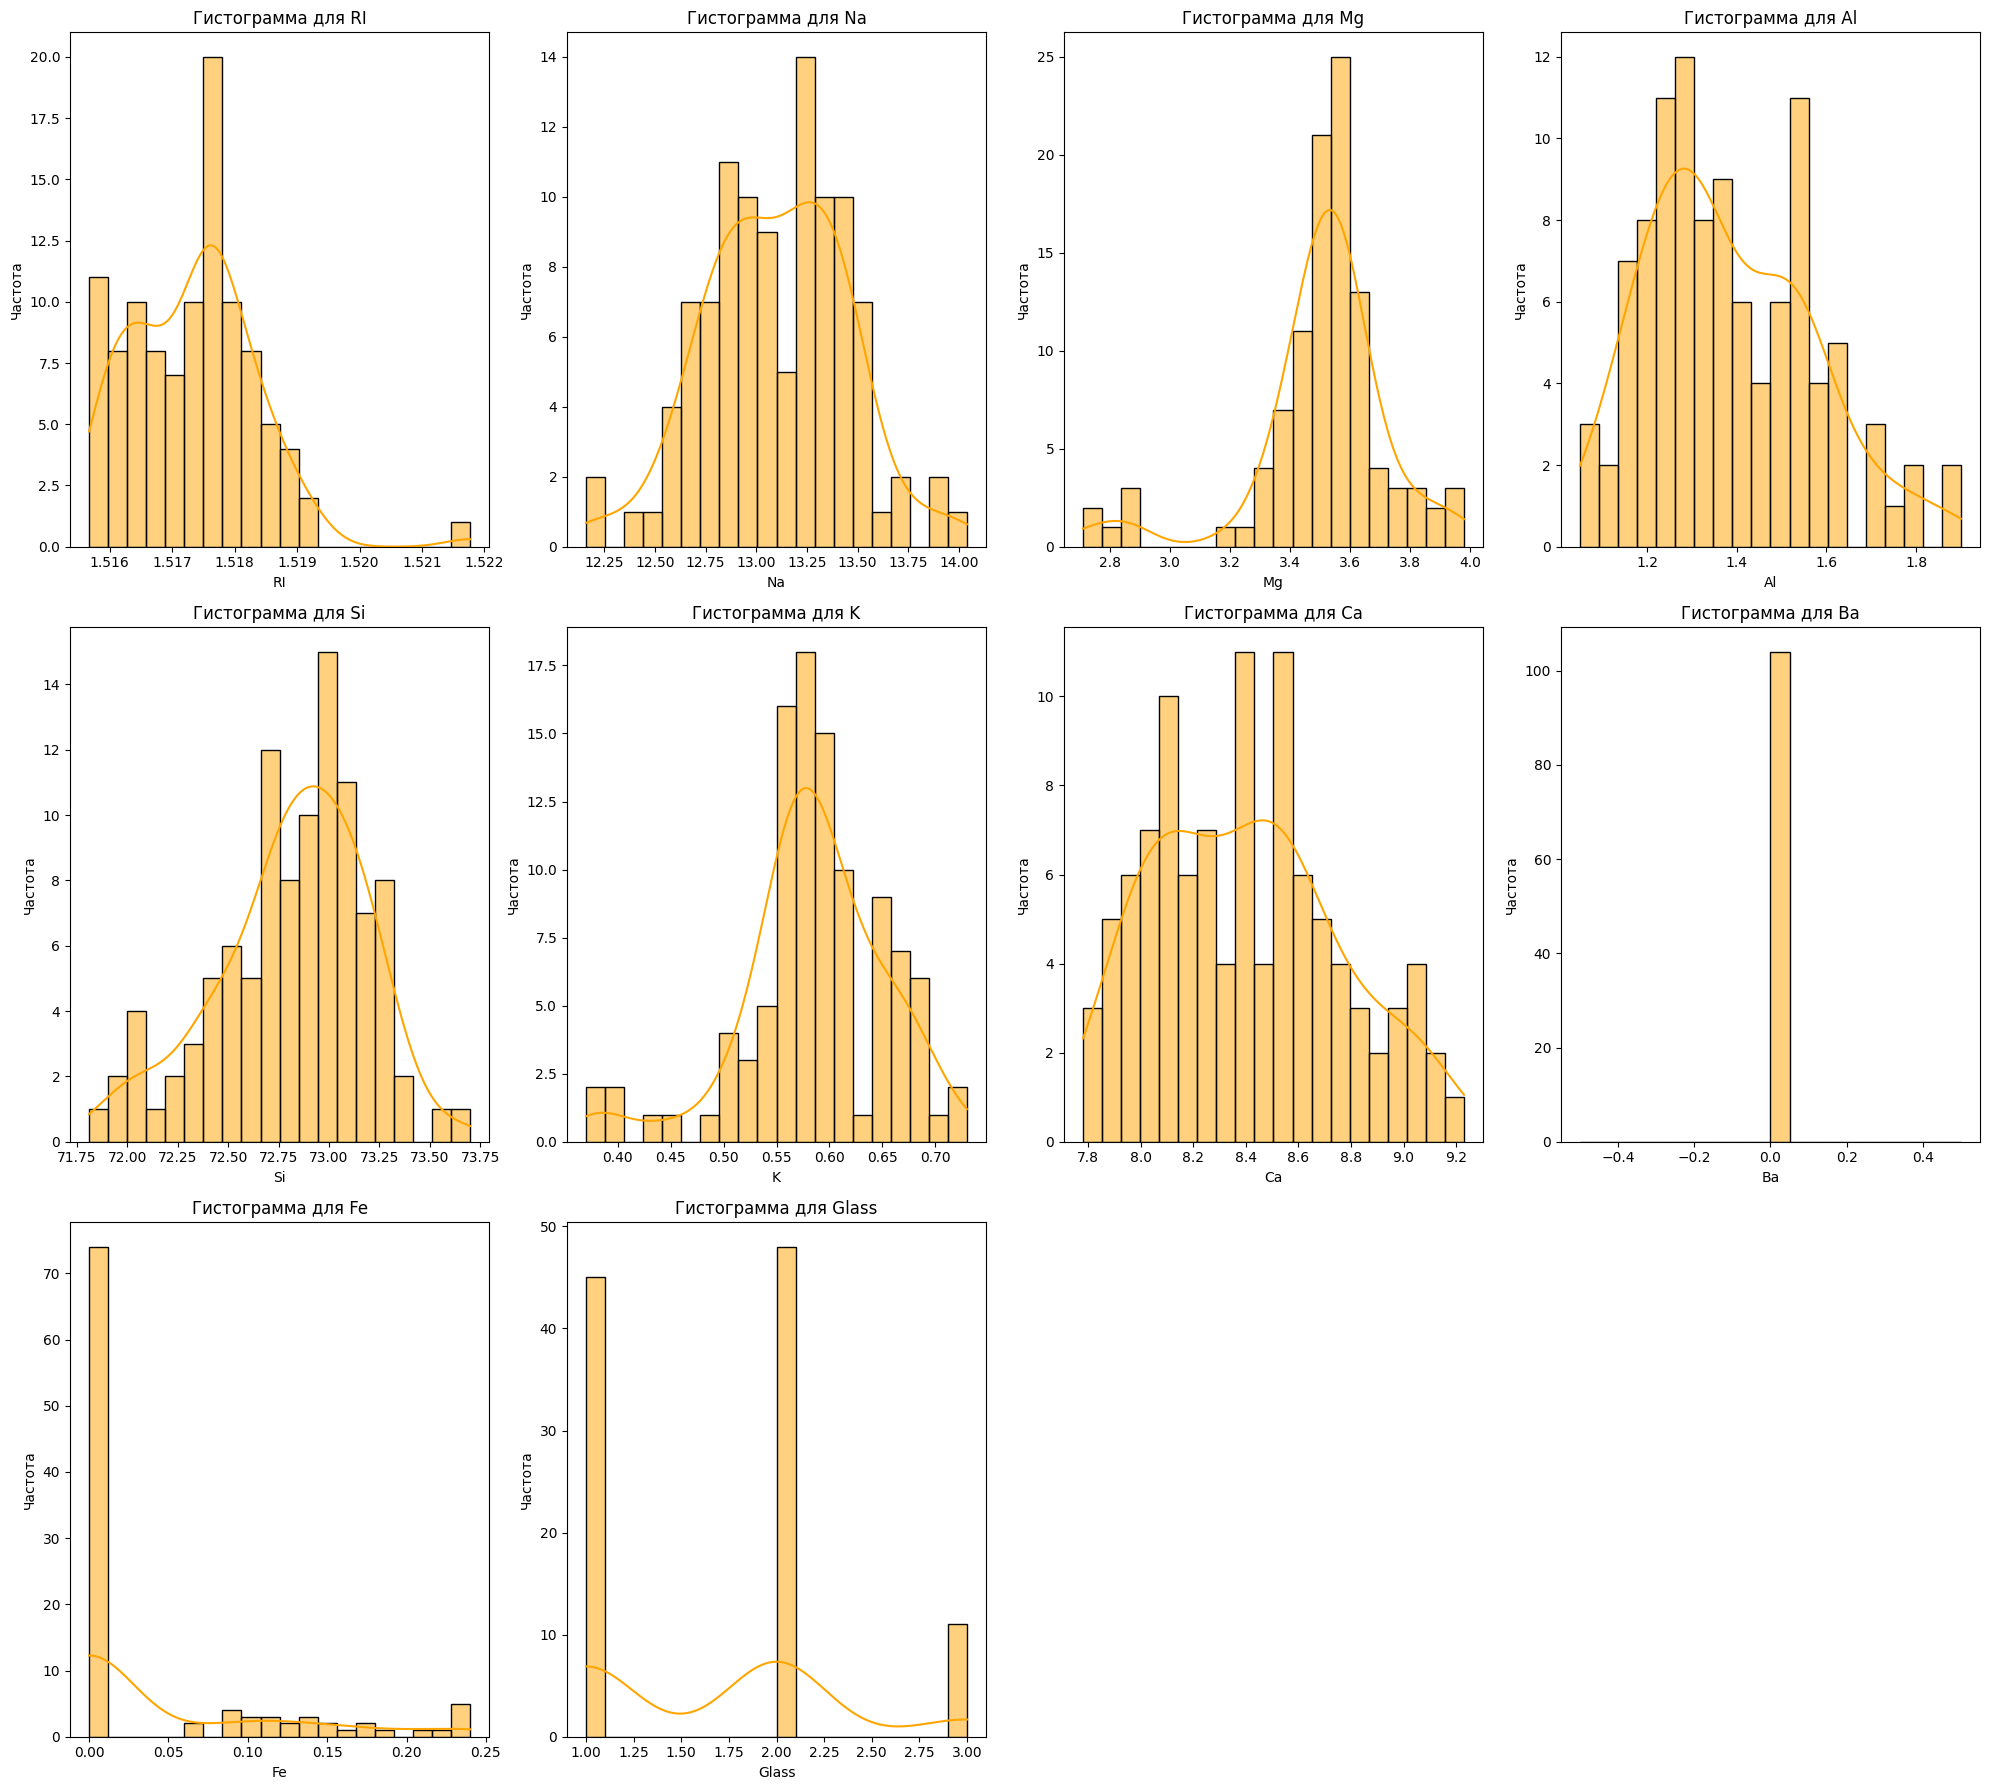

In [694]:
# Устанавливаем количество столбцов для графиков
n_cols = 4
n_rows = (len(df_optimized.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# Построение гистограмм с KDE для числовых столбцов
for idx, col in enumerate(df_optimized.columns):
    sns.histplot(df_optimized[col], kde=True, ax=axes[idx], color='orange', bins=20)
    axes[idx].set_title(f'Гистограмма для {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

# Удаляем пустые оси, если их больше, чем нужных
for i in range(len(df_optimized.columns), len(axes)):
    fig.delaxes(axes[i])



plt.tight_layout()
plt.show()


Проверка выбросов

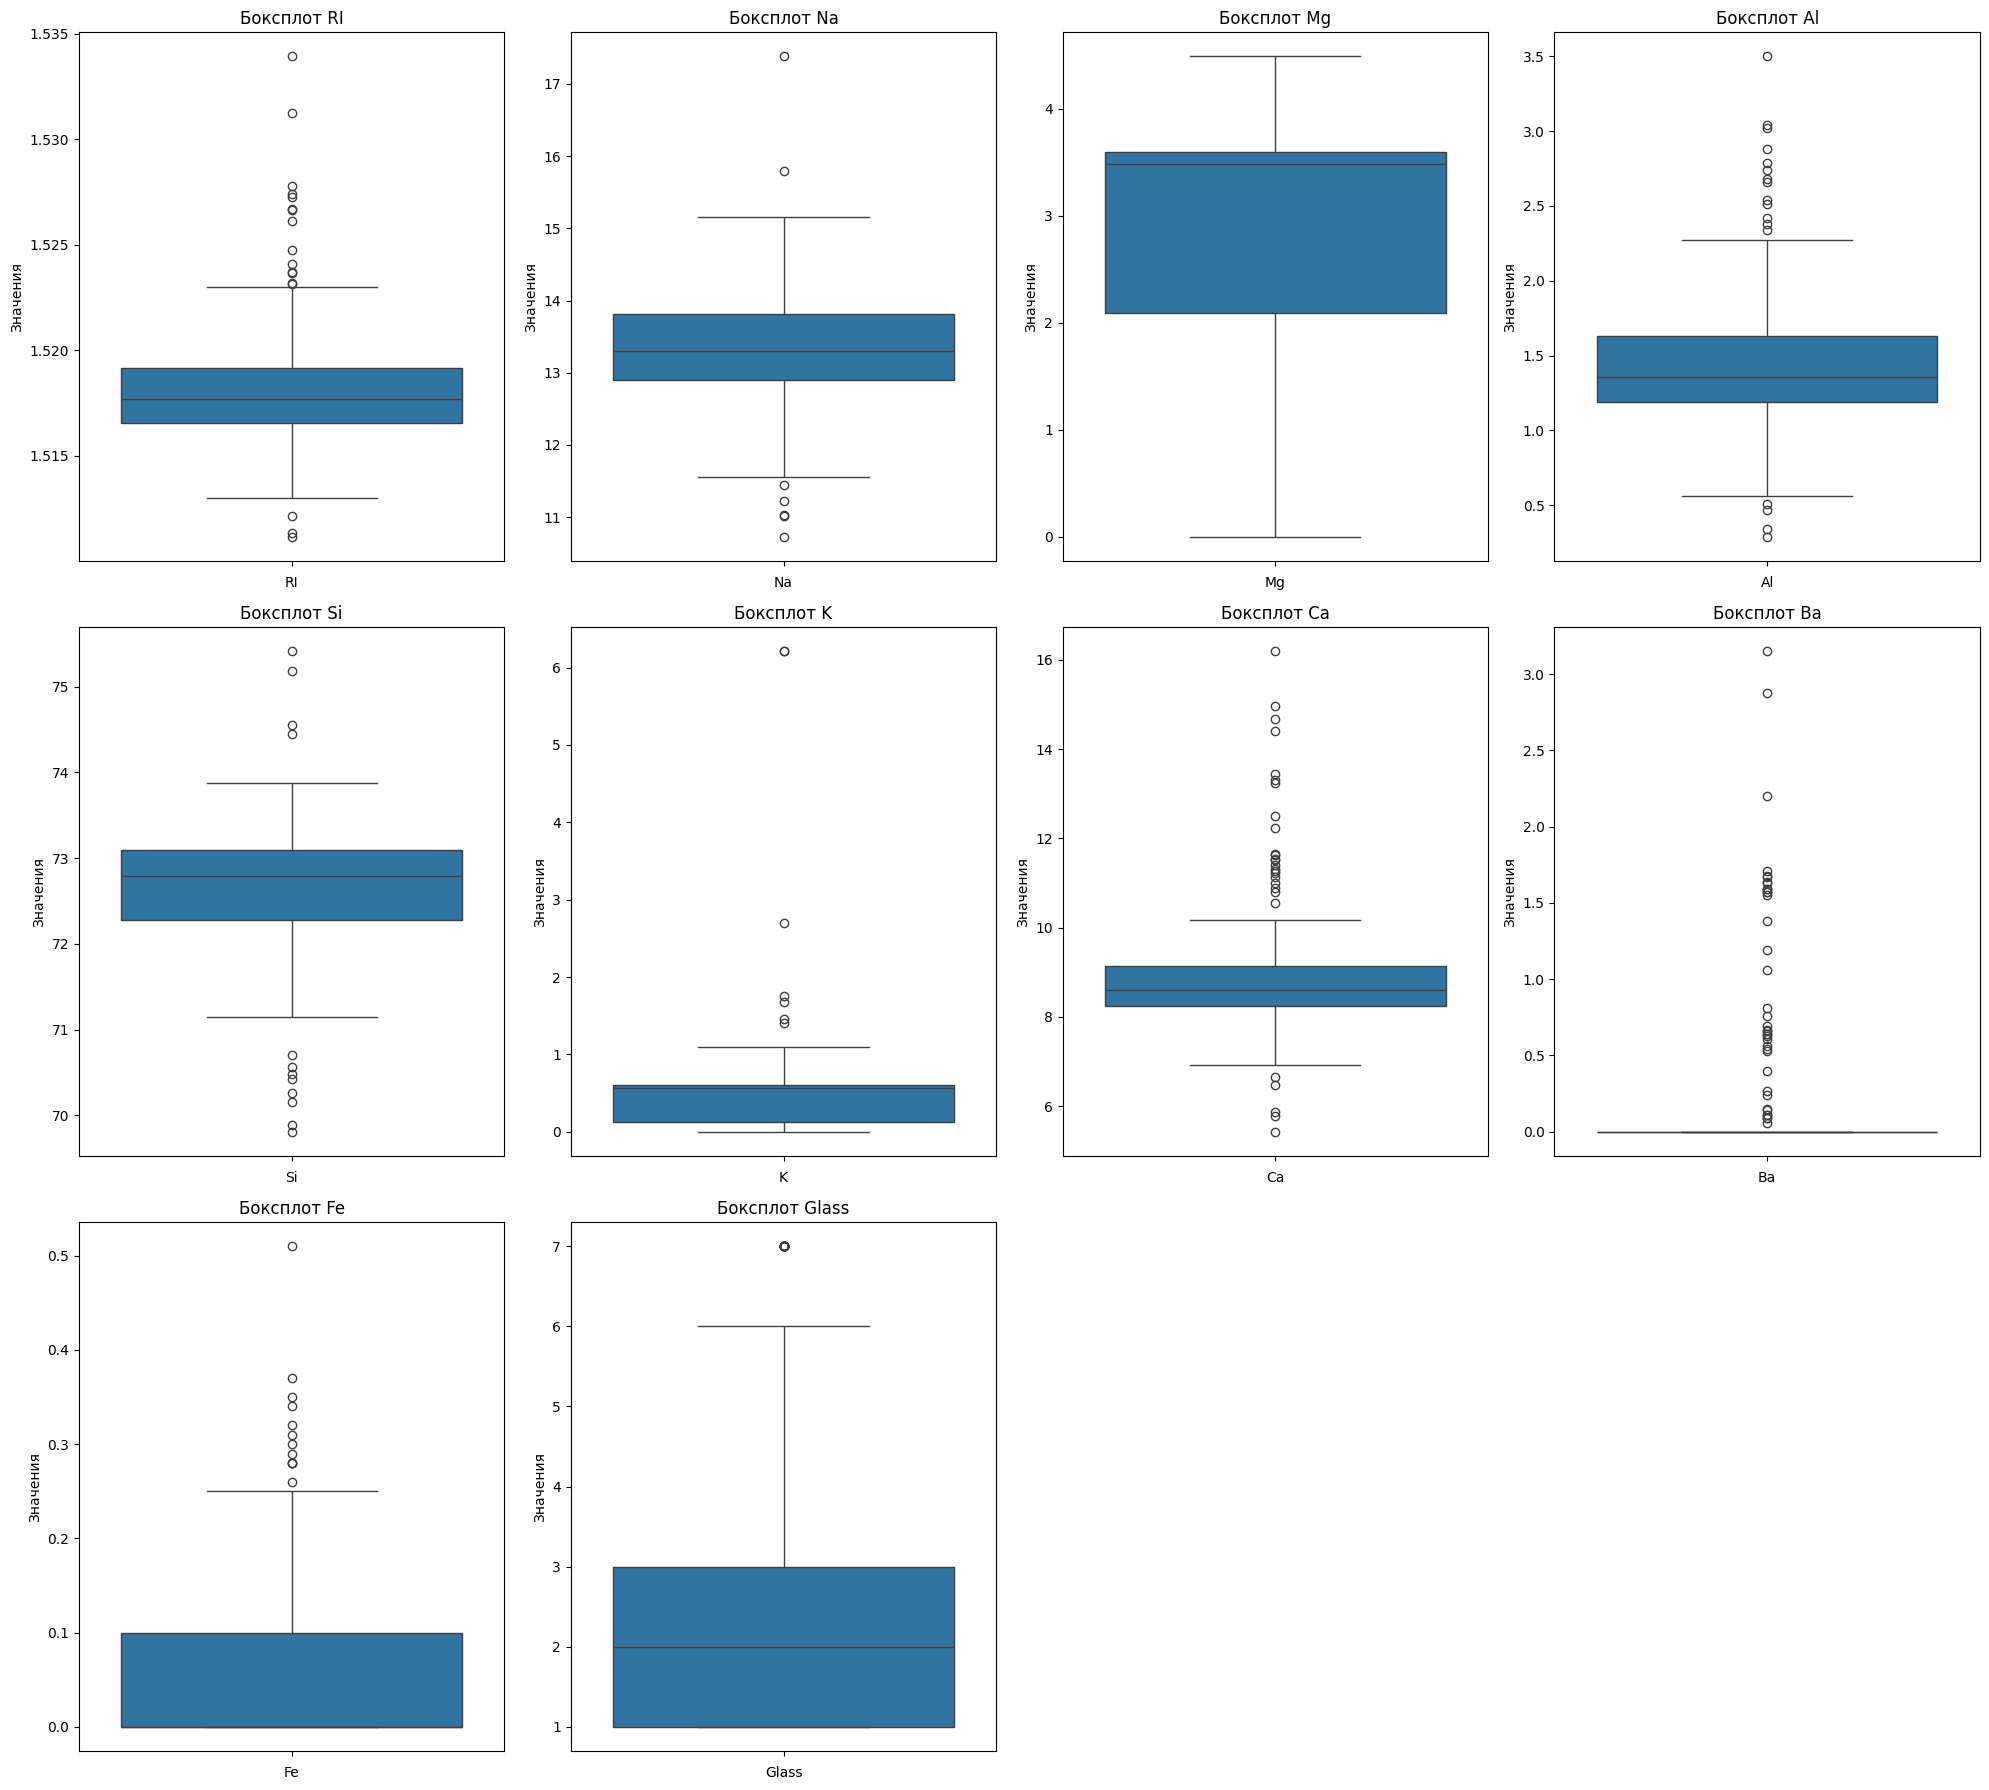

In [667]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

# Числовые столбцы для визуализации
numerical_columns = df_optimized.select_dtypes(include=['number']).columns

for idx, col in enumerate(numerical_columns):
    sns.boxplot(y=df_optimized[col], ax=axes[idx])
    axes[idx].set_title(f'Боксплот {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Значения')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Выбросы есть везде, кроме Mg. Посмотрим, как данные кореллируют, чтобы определить какие выбросы можно удалить.

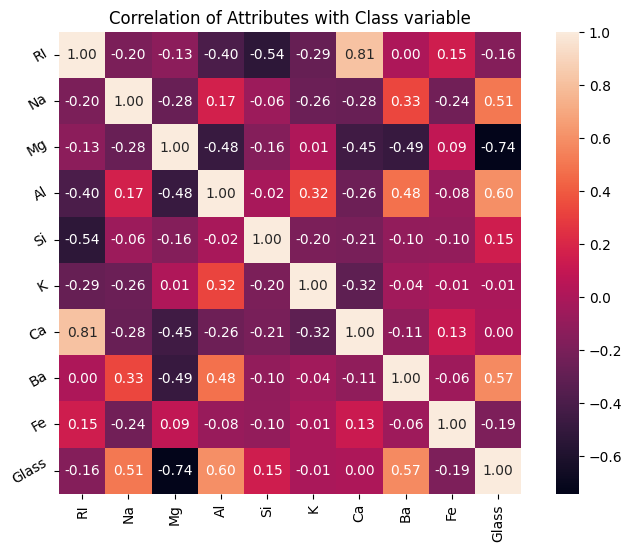

In [668]:
correlation = df_optimized.corr()

plt.figure(figsize=(9,6))
plt.title('Correlation of Attributes with Class variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

Можем заметить что целевое значение Glass
- сильно коррелирует Al, Na и Ba
- очень сильно отрицательно коррелирует с Mg
- есть корреляция с Si
- tcnm отрицательная корреляция с коэффициентом преломления и Fe
- почти не зависит от K и Ca

Также видно, что все,кроме K и Fe сильно коррелируют между собой

In [669]:
# Обработка выбросов
def remove_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df_optimized = remove_outliers(df_optimized, df_optimized.columns)

In [670]:
X = df_optimized.drop(target_column, axis=1)
y = df_optimized[target_column]

Скалирование данных

In [671]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Балансировка классов

In [672]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [673]:
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
    )


Решим проблему высокой корреляции данных

In [674]:
pca = PCA(n_components=new_X_train.shape[1])
pca.fit(new_X_train)

PCA(n_components=9)

Проверим сколько компонент дают 90% дисперсии

In [675]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.23, 0.15, 0.13, 0.1 , 0.06, 0.05, 0.  , 0.  ])

Достаточно 7-и компонент

### Обучение модели с новыми данными

Переопределим модель

In [676]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", KNeighborsClassifier(n_neighbors=3, metric='manhattan'))
))

In [677]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

Сделаем предсказания

In [678]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### Оценка качетсва модели с улучшеным бейзлайном

In [679]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [680]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.876493,0.92963
1,Balanced Accuracy,0.878767,0.92963
2,Precision,0.879413,0.92963
3,Recall,0.878767,0.92963


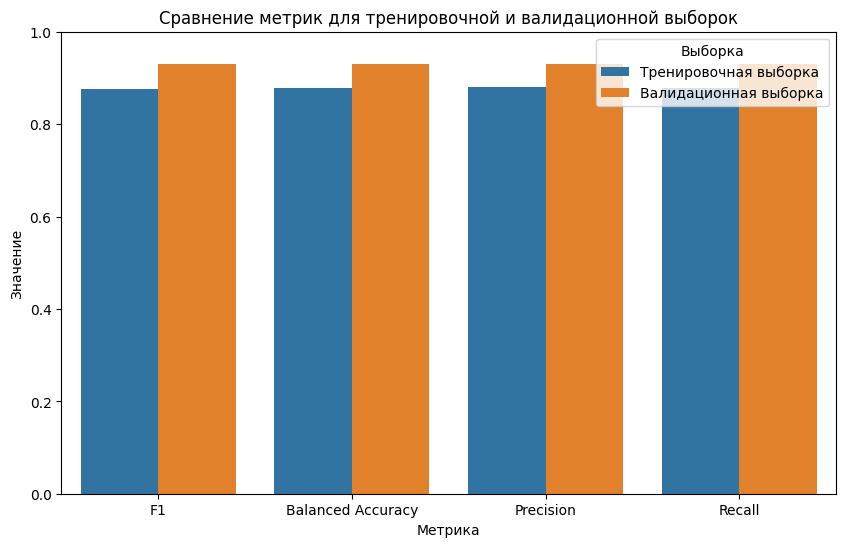

In [681]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Резюме:
На качество модели повлияли, как входные данные, так и параметры самой модели:
- При помощи квантилей я удалил выбросы
- Скалировал данные StandartScaller'ом
- Избавился от дисбалана классов
- Избавился от высокой кореляции фичей
- Подобрал параметры моделей (кол-во соседей и метрику)

## 4. Имплементация алгоритма машинного обучения

### Реализация модели

In [682]:
class MyKNeighborsClassifier:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        return self

    def predict(self, x):
        x = np.array(x)
        manhattan_distances = self._calc_manhattan_distances(self.X, x)
        indices = np.argsort(manhattan_distances, axis=0)[:self.n_neighbors, :]
        neighbors = self.y[indices]
        neighbors_df = pd.DataFrame(neighbors)
        most_frequent = neighbors_df.mode(axis=0).iloc[0]
        return most_frequent.to_numpy()

    @staticmethod
    def _calc_manhattan_distances(data1, data2):
        diff = np.abs(data1[:, np.newaxis, :] - data2[np.newaxis, :, :])
        manhattan_distances = diff.sum(axis=2)
        return manhattan_distances

### Обучение 

In [683]:
model = MyKNeighborsClassifier()
model.fit(X_train, y_train)

In [684]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

###  Оценка качества модели

In [685]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [686]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.815910,0.634848
1,Balanced Accuracy,0.793312,0.607937
2,Precision,0.870587,0.676389
3,Recall,0.793312,0.607937


Визуализация

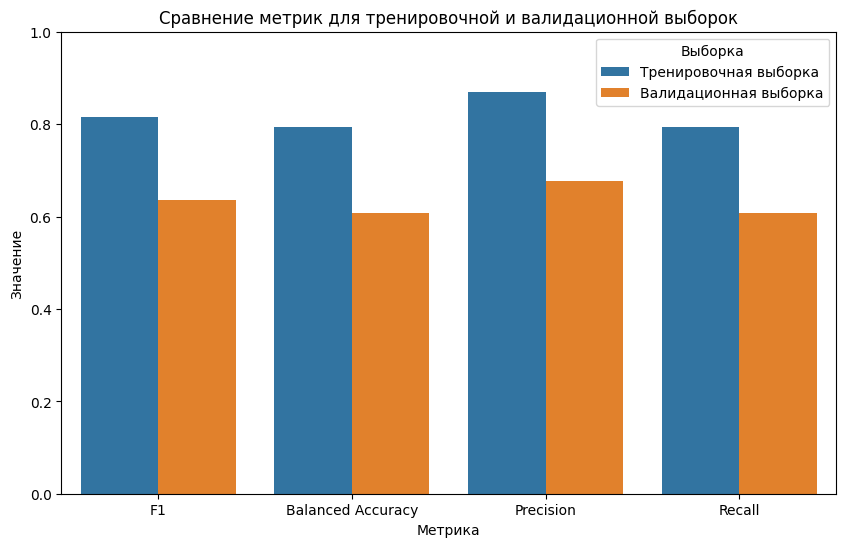

In [687]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучение с улучшенным бейзлайном

In [688]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", MyKNeighborsClassifier())
))

In [689]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 <__main__.MyKNeighborsClassifier object at 0x00000142867CB7C0>)])

In [690]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

###  Оценка качества модели

In [691]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [692]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.876493,0.92963
1,Balanced Accuracy,0.878767,0.92963
2,Precision,0.879413,0.92963
3,Recall,0.878767,0.92963


Визуализация

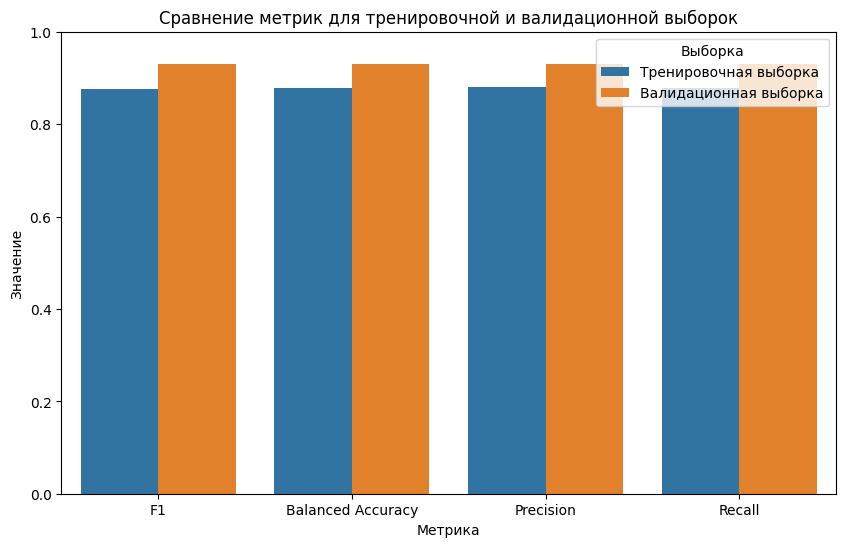

In [693]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Вывод:
- KNN не требует долгого обучения (метод fit просто подставлял входные данные)
- На маленьком датасете предсказание вычисляется довольно быстро, однако для более внушительных расчетов нужно оптимизировать метод перебора соседей
- Самописаная модель делает предсказания с точностью модели sklearn, что не может не радовать!